In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-04-07 23:32:09.531893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 23:32:09.531980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 23:32:09.533685: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/simple-dinosurus-dataset/pterodactyl/37.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/35.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/11.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/31.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/4.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/40.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/33.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/9.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/14.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/1.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/39.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/20.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/38.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/2.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/10.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/36.png
/kaggle/input/simple-dinosurus-dataset/pterodactyl/18.png
/kaggle/input/simp

In [2]:
df = pd.read_csv("/kaggle/input/jurassic-park-the-exhaustive-dinosaur-dataset/data.csv")
df = df.get(['name','lived_in','diet'])

#handling and changing country name - USA to United States of America (Geopandas uses United States of America - making it easier to plot using out function)
country_list = []
for country in df.get('lived_in'):
    if country == 'USA':
        country_list.append('United States of America')
    else:
        country_list.append(country)
df = df.assign(lived_in = country_list)

#adding the missing species - pterodactyl, brontosaurus
df.loc[len(df.index)] = ['pterodactyl','Germany','carnivores']
df.loc[len(df.index)] = ['brontosaurus','United States of America','carnivores']

df2 = pd.DataFrame()
name_data = ['ankylosaurus', 'brachiosaurus', 'compsognathus', 'corythosaurus', 'dilophosaurus', 'pterodactyl', 'brontosaurus',  'dimorphodon', 'gallimimus', 'microceratus', 'pachycephalosaurus', 'parasaurolophus', 'spinosaurus', 'stegosaurus', 'triceratops', 'tyrannosaurus', 'velociraptor']
df2 = df2.assign(name = name_data)

#df has 309 species while other image dataset has only 15 - so we merged it to eliminate the extra species.
dino_df = pd.merge(df,df2,on='name',how= 'inner')

In [3]:
#creating a list of file_paths to images of 15 species - by accessing the dataset of images.
file_path_list = list()
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path_list.append(os.path.join(dirname, filename))

In [4]:
#creating a list of names 15 species.
name_list = list()
for path in file_path_list:
    name_list.append(path.split('/')[-2].split('_')[0].lower())

In [5]:
#merging names of species with file_paths to corresponding images.
name_link_df = pd.DataFrame().assign(name = name_list, file_path = file_path_list)
name_link_df['name']=name_link_df['name'].apply(lambda x: 'tyrannosaurus' if x == 'trex' else x)

In [6]:
#merging dataframe to assign each species and filepath to where the species populously lived.
merged_df = pd.merge(name_link_df,dino_df,on = 'name',how='inner')
merged_df

,name,file_path,lived_in,diet
0,pterodactyl,/kaggle/input/simple-dinosurus-dataset/pteroda...,Germany,carnivores
1,pterodactyl,/kaggle/input/simple-dinosurus-dataset/pteroda...,Germany,carnivores
2,pterodactyl,/kaggle/input/simple-dinosurus-dataset/pteroda...,Germany,carnivores
3,pterodactyl,/kaggle/input/simple-dinosurus-dataset/pteroda...,Germany,carnivores
4,pterodactyl,/kaggle/input/simple-dinosurus-dataset/pteroda...,Germany,carnivores
...,...,...,...,...
195,triceratops,/kaggle/input/simple-dinosurus-dataset/tricera...,United States of America,herbivorous
196,triceratops,/kaggle/input/simple-dinosurus-dataset/tricera...,United States of America,herbivorous
197,triceratops,/kaggle/input/simple-dinosurus-dataset/tricera...,United States of America,herbivorous
198,triceratops,/kaggle/input/simple-dinosurus-dataset/tricera...,United States of America,herbivorous


In [7]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range =40,
                                   shear_range = 0.2,
                                   horizontal_flip = True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory('/kaggle/input/simple-dinosurus-dataset', 
                                                   target_size=(180, 180),
                                                   batch_size=32,
                                                   class_mode='categorical',
                                                   shuffle=True)


Found 200 images belonging to 5 classes.


In [8]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory('/kaggle/input/simple-dinosurus-dataset', 
                                                             target_size=(180, 180),
                                                             batch_size=32,   
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 200 images belonging to 5 classes.


In [9]:
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape = (180,180,3)))
model.add(layers.Conv2D(64, 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(128, 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D())
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(128, activation = 'relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(5, activation = 'softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123904)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 123904)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    15,859,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,232,325 (61.92 MB)

 Trainable params: 16,231,813 (61.92 MB)

 Non-trainable params: 512 (2.00 KB)

In [11]:
model.compile(
    optimizer= 'adam',
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['Accuracy', 'Precision', 'Recall']
)

In [12]:
history = model.fit(train_generator, validation_data = validation_generator, epochs = 10, callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, mode = 'min', restore_best_weights = True), keras.callbacks.ModelCheckpoint(filepath = 'best_model.keras', monitor = 'val_loss', save_best_only = True, verbose = 1),  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - Accuracy: 0.3751 - Precision: 0.5020 - Recall: 0.1775 - loss: 1.4135 
Epoch 1: val_loss improved from inf to 1.73399, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - Accuracy: 0.3844 - Precision: 0.5090 - Recall: 0.1916 - loss: 1.4001 - val_Accuracy: 0.2000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 1.7340 - learning_rate: 0.0010
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - Accuracy: 0.5178 - Precision: 0.6094 - Recall: 0.4412 - loss: 1.2201
Epoch 2: val_loss did not improve from 1.73399
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - Accuracy: 0.5181 - Precision: 0.6084 - Recall: 0.4379 - loss: 1.2193 - val_Accuracy: 0.2000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 2.6205 - learning_rate: 0.0010
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - Accuracy: 0.5976 - Precision: 0.6594 - Recall: 0.4812 - loss: 0.9456
Epoch 3: val_loss did not improve from 1.73399
7/7 ━━━━━━━━━━━━━━━━━━━━ 37

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).get(['continent','name','geometry']) 

def country_plot(country_name):
    country = world[world['name'] == country_name]
    world.plot(color='lightgrey', figsize=(15, 12))
    world_axes = plt.gca()
    country.plot(ax = world_axes, color='darkgreen')
    plt.title(label = 'The dinosaur is found in ' + country_name, fontsize = 15, color = 'darkgreen')
    plt.show()
    
def country_name_plot(dinosaur_name):
    if dinosaur_name == 'trex':
        dinosaur_name = 'tyrannosaurus'
    merged_dino_df = merged_df.set_index('name')
    country = merged_dino_df.loc[dinosaur_name].get('lived_in')
    country_plot(country.iloc[0])


/tmp/ipykernel_206/1613697331.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).get(['continent','name','geometry'])


In [15]:
import cv2
def open_img(path):
    img =  cv2.imread(path)
    return cv2.resize(img, (180,180))

path = input('enter the path of the image you want to search: ')
#'/kaggle/input/simple-dinosurus-dataset/pterodactyl/31.png'
output = model.predict(tf.expand_dims(open_img(path), axis=0))
output = output.tolist()

enter the path of the image you want to search:  /kaggle/input/simple-dinosurus-dataset/pterodactyl/31.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


In [16]:
labels = list(train_generator.class_indices.keys())
dino_name = sorted(list(zip(labels, list(output[0]))), key = lambda x: x[1], reverse = True)[0][0]

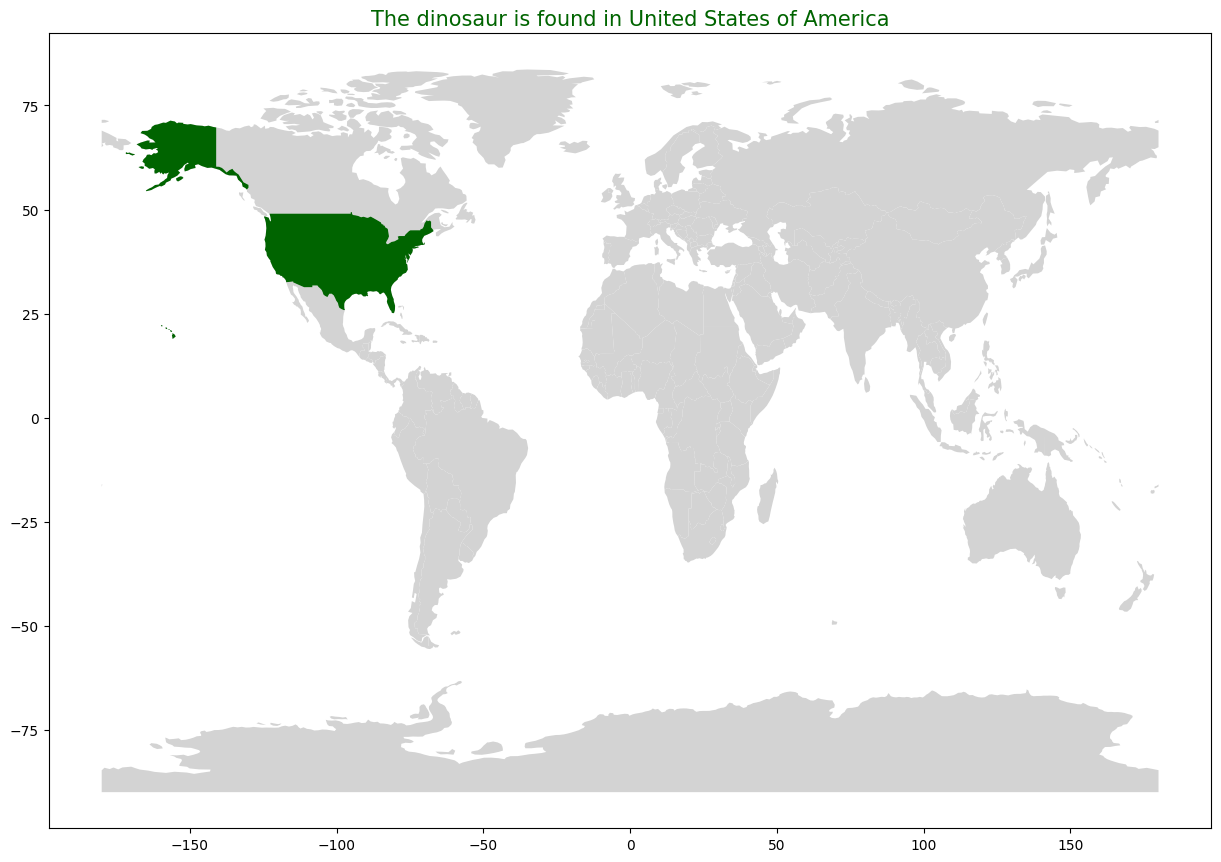

In [17]:
country_name_plot(dino_name)